# Miram Atie | Akos Furton | Zhi Xuan Pek | Dewati Perdani | Deniz Reckermann | Li Qi
### Group HW 3
### 20 December 2016

## Q2. Bass Model

The Bass model is the following equation

$$
F_t = (p + q[\frac{C_{t-1}}{m}])(m - c_{t-1})
$$

Where $m$ is the estimated size of the market, $p$ is the likelihood of people who would adopt the product assuming no influence from others, while $q$ is the likelihood of adopting the product from being influenced by someone else in their network who has adopted the product.

Our aim is to estimate the unknown parameters $m$, $p$, and $q$. To do this, given a data set, we attempt to find a solution set $(m,p,q)$ such that the squared difference between the forecast $F_t$ and the actual adoptees $S_t$ at all time periods $t$ is minimised.

In the context of the DOCTOR data set, $C_t$ is the cumulative revenue earned at time $t$ while $S_t$ is the revenue earned at time $t$ and $F_t$ is the forecasted accumulated revenue. There are 12 time periods in this data set. Since revenue is simply a multiple of the number of "adoptees" (assuming number of people who watch the movie more than once are negligible), we can use the revenue as the "number of adoptees".

Finally, we estimate the parameters with an optimisation problem to minimise squared errors as follows.

$$
\begin{aligned}
min & \sum_{i=1}^{12} (F_t - S_t)^2\\
s.t \text{ }& F_t = (p + q[\frac{C_{t-1}}{m}])(m - c_{t-1}) & t = 2,...,12 \\
& F_1 = m p
\end{aligned}
$$

Note that since this problem is not convex, out solution is not guaranteed to be a global minimum.

### Rolling-Horizon estimate

To obtain a rolling-horizon estimate, we use a subset of the data to estimate the parameters and forecast the revenue of the next time period. Running the model in AMPL using the different subsets (up to time $t$), we get the following estimates of the parameters and the forecast of the next period.

\begin{array}{c|ccc}
t & m & p & q & F_{t+1} \\
\hline
4 & 15.2956 & 0.0942142 & 1.66781 & 5.565598 \\
5 & 20.1184 & 0.07872 & 1.30893 & 0 & \\
6 & 25.8154 & 0.0737613 & 0.927715 & 0 \\
7 & 28.7628 & 0.0724826 & 0.773655 & 0 \\
8 & 30.8454 & 0.0722345 & 0.673796 & 0 \\
9 & 32.4913 & 0.0724768 & 0.597851 & 0 \\
10& 33.6167 & 0.0728771 & 0.546953 & 0 \\
11& 34.3128 & 0.0732449 & 0.515545 & 0 \\
12& 34.85 & 0.0735885 & 0.491362 & 0
\end{array}

As we can see from the results above, the rolling-horizon estimate does not do a good job of forecasting the next period's revenue. The solution will set $m$, the market size, to be the market size at time $t-1$, $C_{t-1}$ (accumulated revenue). As such, the market is saturated and has no more room to grow for the next period. Therefore, in order to obtain accurate estimates with the rolling horizon method, we would need $m$ to be known beforehand through other methods such as surveys and market expertise.

One pattern that we notice is that as $t$ increases, the parameters $m$, $p$ and $q$ seem to converge to different points. With added data, we might see these values eventually converge to a proper estimate of the true parameters.

### Final Estimate

Using all the data, we obtain the final estimate of the parameters,

\begin{array}{ccc}
m & p & q\\ \hline
34.85 & 0.0735885 & 0.491362
\end{array}

This is exactly the same as the estimate obtained in the article.

Finall, the estimate of the revenue over time is shown in the graph below.

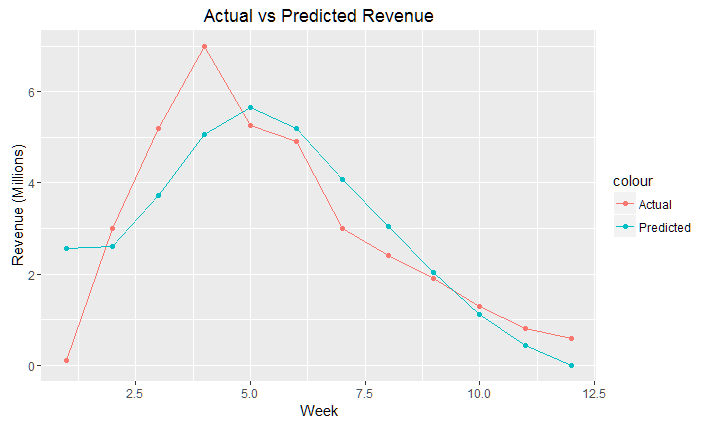

In [2]:
from IPython.display import Image
Image(filename="q2plot.png")

The predicted revenue obtained in our graph very closely matches the one found in the article as well.

## Code for Question 3a

#### Package Imports

In [54]:
import networkx as nx
import pandas as pd
import community
import matplotlib.pyplot as plt
from os import listdir
import re
import statsmodels.formula.api as sm

Import household dataset and villages included in cross-sectional data

In [55]:
household = pd.read_excel('/Users/Akos/Desktop/Networks HW3/household.xlsx')
cross_sectional = pd.read_excel('/Users/Akos/Desktop/Networks HW3/cross_sectional.xlsx')

Combine microfinance adoption data with household characteristics

In [56]:
def find_csv_filenames(path_to_dir, suffix = ".csv"):
    filenames = listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

filenames = find_csv_filenames('/Users/Akos/Desktop/Networks HW3/MF Dummy/')

MF = []
for file in filenames:
    address = '/Users/Akos/Desktop/Networks HW3/MF Dummy/'+file
    village = int(re.search(r'\d+', file).group())
    village_MF = pd.read_csv(address, sep = ',', header = None).reset_index()
    village_MF['village'] = village
    village_MF.columns = ['index', 'MF', 'village']
    village_MF['adjmatrix_key'] = village_MF['index'] + 1
    MF.append(village_MF)

result = pd.concat(MF)

household_merge = pd.merge(household, result, how = "right", on = ['adjmatrix_key', 'village'])

Calculate network centrality measures for each village

In [57]:
filenames = find_csv_filenames('/Users/Akos/Desktop/Networks HW3/1. Network Data/')

adj = []

for file in filenames:
    address = '/Users/Akos/Desktop/Networks HW3/1. Network Data/' + file
    villnum = int(re.search(r'\d+', file).group())
    village = pd.read_csv(address, sep = ',', header = None).as_matrix()
    adj_matrix = nx.from_numpy_matrix(village)
    degree = adj_matrix.degree()
    degree_pd = pd.DataFrame.from_dict(degree, orient = 'index').reset_index()
    eigenvector = nx.eigenvector_centrality_numpy(adj_matrix)
    eigenvector_pd = pd.DataFrame.from_dict(eigenvector, orient = 'index').reset_index()
    betweenness = nx.betweenness_centrality(adj_matrix)
    betweenness_pd = pd.DataFrame.from_dict(betweenness, orient = 'index').reset_index()
    closeness = nx.closeness_centrality(adj_matrix)
    closeness_pd = pd.DataFrame.from_dict(closeness, orient = 'index').reset_index()

    centrality_merge = degree_pd.merge(eigenvector_pd,on='index').merge(betweenness_pd,on='index').merge(closeness_pd, on='index')
    centrality_merge.columns = ['index', 'Degree', 'Eigenvector', 'Betweenness', 'Closeness']
    centrality_merge['adjmatrix_key'] = centrality_merge['index'] + 1
    centrality_merge['village'] = villnum
    adj.append(centrality_merge)

result1 = pd.concat(adj)

Merge village network characteristics with household data

Filter data to include only those villages in the cross-sectional results

In [58]:
data = pd.merge(household_merge, result1, how = "left", on = ['adjmatrix_key', 'village'])
villages_to_use = cross_sectional['village'].to_frame()
real_data = pd.merge(data, villages_to_use, how = 'right', on = 'village')

Aggregate individual household data at a village level

In [59]:
MF = real_data[real_data['leader'] != 1].groupby('village')['MF'].mean().to_frame().reset_index()
hhsurveyed = real_data[real_data['hhSurveyed'] == 1]
degree_leader = hhsurveyed[hhsurveyed['leader'] == 1].groupby('village')['Degree'].mean().to_frame().reset_index()
village_size = real_data.groupby('village').size().to_frame().reset_index()
eigenvector_centrality = real_data[real_data['leader'] == 1].groupby('village')['Eigenvector'].mean().to_frame().reset_index()
betweenness_centrality = real_data[real_data['leader'] == 1].groupby('village')['Betweenness'].mean().to_frame().reset_index()
closeness_centrality = real_data[real_data['leader'] == 1].groupby('village')['Closeness'].mean().to_frame().reset_index()
frac_leaders = (real_data[real_data['leader'] == 1].groupby('village').size() / real_data.groupby('village').size()).to_frame().reset_index()
cross_sectional = pd.merge(MF, eigenvector_centrality, how = 'left', on = 'village') \
                    .merge(village_size, on = 'village') \
                    .merge(degree_leader, on = 'village') \
                    .merge(betweenness_centrality, on = 'village') \
                    .merge(closeness_centrality, on = 'village') \
                    .merge(frac_leaders, on = 'village')
cross_sectional.columns = ['Village', 'MF', 'Eigenvector', 'Size', 'Degree', 'Betweenness', 'Closeness', 'FracLeader']

#betweenness and closeness are not the same as cross_sectional, but are slightly lower (due to networkx calculating only shortest path)

In [60]:
cross_sectional.head()

,Village,MF,Eigenvector,Size,Degree,Betweenness,Closeness,FracLeader
0,1,0.214286,0.088717,182,21.111111,0.018261,0.410151,0.153846
1,2,0.138728,0.078247,195,15.727273,0.016842,0.329004,0.112821
2,3,0.140078,0.064052,292,16.636364,0.008711,0.354030,0.119863
3,4,0.067873,0.066191,239,16.625000,0.014105,0.335063,0.075314
4,6,0.239130,0.121904,114,13.600000,0.019490,0.383985,0.192982


Perform lienar regressions using village network data to predict rates of microfinance adoption

In [61]:
model1 = sm.ols(formula = "MF ~ Size", data = cross_sectional).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                     MF   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     12.40
Date:                Tue, 20 Dec 2016   Prob (F-statistic):            0.00107
Time:                        14:07:40   Log-Likelihood:                 51.656
No. Observations:                  43   AIC:                            -99.31
Df Residuals:                      41   BIC:                            -95.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3458      0.047      7.342      0.0

In [62]:
model2 = sm.ols(formula = "MF ~ Degree", data = cross_sectional).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                     MF   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.030
Date:                Tue, 20 Dec 2016   Prob (F-statistic):              0.316
Time:                        14:07:40   Log-Likelihood:                 46.509
No. Observations:                  43   AIC:                            -89.02
Df Residuals:                      41   BIC:                            -85.50
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2478      0.063      3.913      0.0

In [63]:
model3 = sm.ols(formula = "MF ~ Eigenvector", data = cross_sectional).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                     MF   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     14.23
Date:                Tue, 20 Dec 2016   Prob (F-statistic):           0.000512
Time:                        14:07:41   Log-Likelihood:                 52.382
No. Observations:                  43   AIC:                            -100.8
Df Residuals:                      41   BIC:                            -97.24
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.0032      0.049      0.064      

In [64]:
model4 = sm.ols(formula = "MF ~ Eigenvector + Size", data = cross_sectional).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                     MF   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     8.292
Date:                Tue, 20 Dec 2016   Prob (F-statistic):           0.000971
Time:                        14:07:41   Log-Likelihood:                 53.433
No. Observations:                  43   AIC:                            -100.9
Df Residuals:                      40   BIC:                            -95.58
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.1503      0.115      1.309      

In [65]:
model5 = sm.ols(formula = "MF ~ Size + Degree", data = cross_sectional).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                     MF   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     6.128
Date:                Tue, 20 Dec 2016   Prob (F-statistic):            0.00477
Time:                        14:07:41   Log-Likelihood:                 51.722
No. Observations:                  43   AIC:                            -97.44
Df Residuals:                      40   BIC:                            -92.16
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.3621      0.066      5.449      0.0

In [66]:
model6 = sm.ols(formula = "MF ~ Eigenvector + Degree", data = cross_sectional).fit()
print(model6.summary())

                            OLS Regression Results                            
Dep. Variable:                     MF   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     8.410
Date:                Tue, 20 Dec 2016   Prob (F-statistic):           0.000894
Time:                        14:07:41   Log-Likelihood:                 53.522
No. Observations:                  43   AIC:                            -101.0
Df Residuals:                      40   BIC:                            -95.76
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.0768      0.070      1.101      

In [67]:
model7 = sm.ols(formula = "MF ~ Eigenvector + Size + Degree", data = cross_sectional).fit()
print(model7.summary())

                            OLS Regression Results                            
Dep. Variable:                     MF   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     5.874
Date:                Tue, 20 Dec 2016   Prob (F-statistic):            0.00207
Time:                        14:07:42   Log-Likelihood:                 53.991
No. Observations:                  43   AIC:                            -99.98
Df Residuals:                      39   BIC:                            -92.94
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.1619      0.115      1.404      

In [68]:
model8 = sm.ols(formula = "MF ~ Eigenvector + Size + Degree + Betweenness + Closeness", data = cross_sectional).fit()
print(model8.summary())

                            OLS Regression Results                            
Dep. Variable:                     MF   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     4.072
Date:                Tue, 20 Dec 2016   Prob (F-statistic):            0.00480
Time:                        14:07:42   Log-Likelihood:                 55.403
No. Observations:                  43   AIC:                            -98.81
Df Residuals:                      37   BIC:                            -88.24
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       0.3233      0.209      1.543      

## Writeup for Question 3a)

In a study that attempts to predict diffusion rates of microfinance across a set of Indian villages, Banerjee, Chandrasekhar, Duflo, and Jackson implement a set of models that predict whether injection points and network characteristics of a village matter. The paper first creates models based on injection points, village leaders who will start the diffusion process. Through linear regressions, the authors predict which network-based metrics allow for the most effective penetration of microfinance. 

First, the authors test whether the percentage of microfinance adoption is influenced by the size of the village. Based on the results of the regression, village size is a very statistically significant predictor of microfinance adoption, as evidenced by the p-value of 0.001.  Since the coefficient of size is negative, we see that microfinance adoption is more effective in smaller villages.


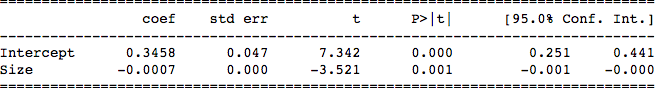

In [10]:
Image(filename="RegressionSize.png")

Then, the model predicts the rate of microfinance adoption based on the degree of the selected community leaders. In this regression, the degree is not statistically significant, as shown by the p-value of 0.316. The number of connections a leader had does not correlate with microfinance adoption. 

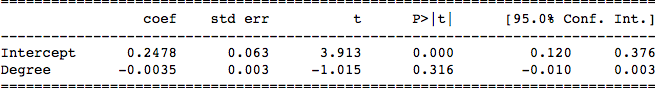

In [11]:
Image(filename="RegressionDegree.png")

Finally, we regress the leaders’ eigenvector centralities with the rate of microfinance adoption. Eigenvector Centrality, as illustrated by its p-value of .001, is extremely significant in predicting the eventual usage of microfinance in a village. Microfinance adoption works best with leaders who are influential in the community and are connected to other important figures.

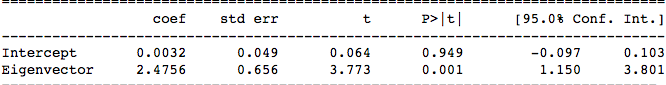

In [12]:
Image(filename="RegressionEigenvector.png")

When predicting the rate of microfinance adoption using multiple predictors, Eigenvector centrality of leaders, village size, and degree of leaders, the regression shows that eigenvector centrality is the only statistically significant predictor of the three (p = .044). Therefore, leaders with high eigenvector centrality are most likely to be effective in diffusing information regarding microfinance throughout a village. Village size and the number of connections a leader has are insignificant. 

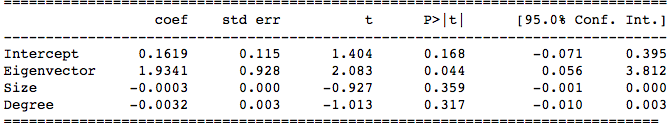

In [13]:
Image(filename="RegressionCombo.png")

Even when adding further predictors to attempt to explain rates of microfinance diffusion, eigenvector centrality outperforms other metrics of leader centrality such as betweeness and closeness centrality. Selecting injection points as leaders who are close to other influential members of the village serves as the most effective means of diffusing knowledge of microfinance in a village.

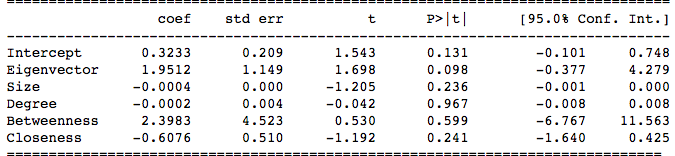

In [14]:
Image(filename="RegressionCentrality.png")

Overall, we see that social dynamics play a large role in the eventual adoption of microfinance. The network characteristics of leaders chosen to initiate the diffusion serve as a significant predictor of the initiative’s success. We see that the villages with the highest success rates in adoption are those with leaders possessing high eigenvector centrality. Such leaders sit close to other influential members of the communities so information spreads across the entire network. Somewhat surprisingly, the number of connections that a leader has is insignificant. Therefore, organizations wishing to spread microfinance should target community leaders who have a high degree of influence across the entire village, not necessarily leaders who have a large number of friends.